## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [656]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [657]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [658]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [659]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 9')

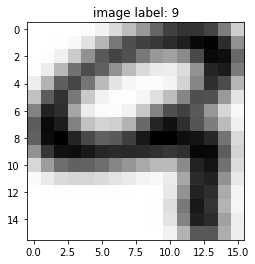

In [660]:
sample_index = 88

plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

### Training the neural network

In [720]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.c1 = nn.Conv2d(1,6, 5) # Convolution kernel 6 layer size 5, stride 1
        self.c2 = nn.Conv2d(6,16, 5) # Convolution kernel 16 layer size 5, stride 1
        #self.c3 = nn.Conv2d(16,32, 5) # Convolution kernel 16 layer size 5, stride 1
        # self.l1 = nn.Linear(16 * 12 * 12, 120)
        self.l1 = nn.Linear(16 * 8 * 8, 120)
        self.l2 = nn.Linear(120, 84)
        self.l3 = nn.Linear(84, 10)
        #self.l3 = nn.Linear(84, 10)
        #self.l3 = nn.Linear(84, 10)
        
        
    def forward(self, inputs):
        h1 = F.relu(self.c1(inputs))
        h2 = F.relu(self.c2(h1))
        #h2 = F.relu(self.c3(h2))
        #print(h1.shape)
        #h3 = F.relu(self.l1(h2.view(h2.shape[0],-1)))
        #h3 = F.relu(self.l1(h1.view(h1.shape[0],-1)))
        h3 = h2.view(h2.shape[0],-1)
        h4 = F.relu(self.l1(h3))
        h5 = F.relu(self.l2(h4))
        #outputs = F.softmax(self.l3(h5), dim=1)# Use softmax as the activation function for the last layer
        #outputs = F.softmax(self.l4(h5), dim=1)# Use softmax as the activation function for the last layer
        #outputs = F.softmax(self.l1(h3), dim=1)# Use softmax as the activation function for the last layer
        outputs = self.l3(h5)

        return outputs

In [741]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 20

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [702]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            #y_pre = model(images.view(batch_size, -1))
            y_pre = model( images)
            #print( labels.shape)
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            #labels_one_hot = torch.FloatTensor(batch_size, 10)
            #labels_one_hot.zero_()
            #labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [742]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/20], Loss: 0.7298
Epoch [2/20], Loss: 0.2979
Epoch [3/20], Loss: 0.2021
Epoch [4/20], Loss: 0.1721
Epoch [5/20], Loss: 0.1383
Epoch [6/20], Loss: 0.1155
Epoch [7/20], Loss: 0.0919
Epoch [8/20], Loss: 0.0902
Epoch [9/20], Loss: 0.0744
Epoch [10/20], Loss: 0.0678
Epoch [11/20], Loss: 0.0568
Epoch [12/20], Loss: 0.0562
Epoch [13/20], Loss: 0.0406
Epoch [14/20], Loss: 0.0487
Epoch [15/20], Loss: 0.0498
Epoch [16/20], Loss: 0.0405
Epoch [17/20], Loss: 0.0417
Epoch [18/20], Loss: 0.0293
Epoch [19/20], Loss: 0.0215
Epoch [20/20], Loss: 0.0383


Text(0.5, 1.0, 'Visualization of convergence')

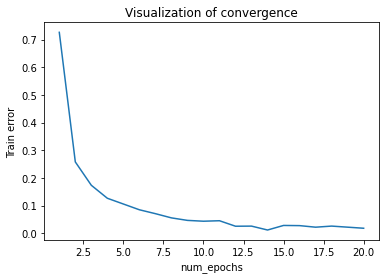

In [723]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [738]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            #images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [743]:
accuracy(val_set, model)

Accuracy of the model : 96.67 %


torch.Size([1, 1, 16, 16])


Text(0.5, 1.0, 'Prediction label: 3')

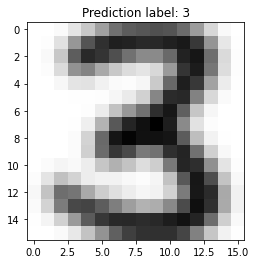

In [744]:
val_index = 66

(image, label) = val_set[val_index]
print(image.unsqueeze(1).shape)
output = model( image.unsqueeze(1) )

#output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [669]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [670]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [745]:
accuracy(test_set, model)

Accuracy of the model : 93.32 %


In [746]:
model

Model(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (l1): Linear(in_features=1024, out_features=120, bias=True)
  (l2): Linear(in_features=120, out_features=84, bias=True)
  (l3): Linear(in_features=84, out_features=10, bias=True)
)